# Model training

In [1]:
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics
import sys

import torch
import torchvision.transforms as transforms
import torchvision.models
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
import time
import torchstain

import data_reader
import dataset
from plots import learning_curve_train

from normalization import normalize_staining

In [2]:
# Choosing device for tensor processing

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using GPU :", device)
else:
    device = torch.device("cpu")
    print("Using CPU ")

Using GPU : cuda:0


In [3]:
# Training and data variables

MODE = "w"
EXP_NAME = "256_tcia_mac" # "test_normalization"#"256_tcia_25ep"#"tcia_effnet"

# DATA_SET_NAME = "data_set_X20_100%_SPLIT" # f"tcia_data_set_SPLIT" # f"train_256_tcia_data_set_SPLIT" #
# DATA_SET_NAME = "train_512_gdc+tcia_normal_data_set_SPLIT"
DATA_SET_NAME = "train_256_tcia_mac_SPLIT"
PATCH_SIZE = 512

BATCH_SIZE = 16
EPOCHS = 25

SIZE_X = PATCH_SIZE
SIZE_Y = PATCH_SIZE

fine_tuning = False

In [4]:
def init_weights(m): # XAVIER initialization for final layer weight initialization
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

def init(fine_tuning=False):
    global net, loss_function, scheduler, optimizer, MODEL_NAME

    if fine_tuning == True:
        print(f"Loading {MODEL_NAME}")
        net = torch.load(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\{MODEL_NAME}.pth") # Model loading

        for param in net.layer4[1].parameters():
           param.requires_grad = True

        '''
        for param in net.features[8].parameters():
            param.requires_grad = True

        for param in net.features[9].parameters():# net.layer4[1].parameters():
            param.requires_grad = True # Unfreezing the last residual block
        '''

        n_params = sum(p.numel() for p in net.fc.parameters())# + sum(p.numel() for p in net.features[8].parameters())

        learning_rate = 1E-5#1E-8 # LR

        optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08)# Optimizer

    else:
        net = torchvision.models.resnet18(pretrained=True).to(device)
        #net = torchvision.models.efficientnet_b1(pretrained=True).to(device) 
    
        net.fc = nn.Sequential(
                    nn.Dropout(p=0.5),  
                    nn.Linear(512, 2),
                    #nn.ReLU(inplace=True),
                    #nn.Linear(512, 2),
                    nn.Softmax(dim = -1)
                    ).to(device)

        for param in net.fc.parameters():
            param.requires_grad = True

        net.fc.apply(init_weights) # Xavier init

        n_params = sum(p.numel() for p in net.fc.parameters())# + sum(p.numel() for p in net.layer4[1].parameters())
    
        learning_rate = 1E-4

        optimizer = optim.Adam(net.fc.parameters(), lr=learning_rate)#, betas=(0.9, 0.999), eps=1e-08)# Optimizer

    print("Number of free parameters: ", n_params)
    #Hyperparameters:
    loss_function = nn.CrossEntropyLoss()  # Loss
    lambda1 = lambda epoch: 0.8 ** epoch # Scheduler
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)


In [5]:
def fwd_pass(X, y, case_ids, train=False):
    if train: 
        net.zero_grad()

    """# TOTAL MEAN AND STD DEV
    mean_set = [166.44544832, 115.25740225, 149.71458135]
    std_set = [51.04418855, 53.39864174, 43.56392919]
    normalize_set = torchvision.transforms.Normalize(mean=mean_set, std=std_set)
    # NORMALIZATION
    mean_gtex = [144.84250856,  90.71206166, 128.46787316]
    std_gtex = [61.96567854, 60.13392162, 51.13692362]
    normalize_gtex = torchvision.transforms.Normalize(mean=mean_gtex, std=std_gtex)

    mean_tcga = [190.30330768, 142.36479088, 173.17902561]
    std_tcga = [38.98271104, 45.96033188, 35.20046394]
    normalize_tcga = torchvision.transforms.Normalize(mean=mean_tcga, std=std_tcga)"""

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    normalize = torchvision.transforms.Normalize(mean=mean, std=std)


    for i, (case_id, x) in enumerate(zip(case_ids, X)):
        X[i] = normalize(X[i]/255)
    
    #plt.imshow(X[0].permute(2,1,0).to("cpu"))
    #plt.show()
    outputs = net(X)
    
    y_pred = [torch.argmax(i) for i in outputs.cpu()]
    y_true = [torch.argmax(i) for i in y.cpu()]

    loss = loss_function(outputs, y)
    conf_m = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=[0, 1])
    acc = sklearn.metrics.accuracy_score(y_true, y_pred)
    f1 = sklearn.metrics.f1_score(y_true, y_pred, average="macro")
    auc = 0# sklearn.metrics.roc_auc_score(y_true, y_pred, labels=[0, 1])# average= "micro" multi_class="ovr") #!!!!

    if train:
        loss.backward() # Calculate gradients using backprop
        #torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=0.0001)# To prevent exploding or vanishing gradients
        optimizer.step() # Updates W and b using previously calculated gradients

    return [acc, loss, conf_m, f1, auc]

In [6]:
def train():
  global net, loss_function, scheduler, optimizer, train_set, val_set, MODEL_NAME, EPOCHS, val_dataloader, train_dataloader
  
  print(MODEL_NAME)
  patience, prev_val_loss = 0, 0

  with open(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\log\\model_{MODEL_NAME}.log", MODE) as f:
    for epoch in range(EPOCHS):
      acc, loss, f1, auc = 0, 0, 0, 0
      val_acc, val_loss, val_f1, val_auc = 0, 0, 0, 0
      conf_m, val_conf_m = np.zeros((2,2)), np.zeros((2,2))

      print("\nEPOCH: ", epoch+1)

      n_patches = sum(len(batch[0]) for batch in iter(train_dataloader))

      for batch_X, batch_y, patch_ids in tqdm(iter(train_dataloader)):
        batch_X, batch_y = batch_X.type(torch.FloatTensor).to(device).permute(0,3,2,1), batch_y.type(torch.FloatTensor).to(device) 
        
        net.train() # Making sure that the model is in training mode
        
        performance_metrics = fwd_pass(batch_X, batch_y, patch_ids, train=True)
        acc_aux, loss_aux, conf_m_aux, f1_aux, auc_aux = performance_metrics[0], performance_metrics[1], performance_metrics[2], performance_metrics[3], performance_metrics[4]
        acc += acc_aux*(len(batch_X)/n_patches) # Calculating the average loss and acc through batches sum ACCi*Wi/N (Wi = weight of the batch)
        loss += loss_aux*(len(batch_X)/n_patches)
        conf_m += conf_m_aux
        f1 += f1_aux*(len(batch_X)/n_patches)
        auc += auc_aux*(len(batch_X)/n_patches)

      for batch_X, batch_y, patch_ids in tqdm(iter(val_dataloader)):

        batch_X, batch_y = batch_X.type(torch.FloatTensor).to(device).permute(0, 3, 2, 1), batch_y.type(torch.FloatTensor).to(device)

        net.eval() # Making sure that the model is not training and deactivate droptout
        
        with torch.no_grad(): # Disable all computations, works together with net.eval()
          performance_metrics = fwd_pass(batch_X, batch_y, patch_ids, train=False)
          
        acc_aux, loss_aux, conf_m_aux, f1_aux, auc_aux = performance_metrics[0], performance_metrics[1], performance_metrics[2], performance_metrics[3], performance_metrics[4]  
        val_acc += acc_aux*(len(batch_X)/len(val_set)) # Calculating the average loss and acc through batches sum ACCi*Wi/N (Wi = weight of the batch)
        val_loss += loss_aux*(len(batch_X)/len(val_set))
        val_conf_m += conf_m_aux
        val_f1 += f1_aux*(len(batch_X)/len(val_set))
        val_auc += auc_aux*(len(batch_X)/len(val_set))

        
      print("Val loss: ", val_loss.item(), " Train loss: ", loss.item(), "\n")
      print("Val acc: ", val_acc, " Train acc: ", acc, "\n")
      print("Val AUC: ", val_auc, " Train AUC: ", auc,"\n")
      print("Val f1: ", val_f1, " Train f1: ", f1, "\n")
      print("Val CONF: \n", val_conf_m, "\nTrain CONF: \n", conf_m, "\n")

      conf_m = f"{conf_m[0][0]}+{conf_m[0][1]}+{conf_m[1][0]}+{conf_m[1][1]}"
      val_conf_m = f"{val_conf_m[0][0]}+{val_conf_m[0][1]}+{val_conf_m[1][0]}+{val_conf_m[1][1]}"
    
      f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),3)},{round(float(loss),4)},{conf_m},{round(float(auc),4)},")
      f.write(f"{round(float(val_acc),3)},{round(float(val_loss),4)},{val_conf_m}, {round(float(val_auc),4)}\n")
      f.write("\n\n")

      # Early stopping, if the difference between loss and validation loss 
      # is bigger than the threshold for 3 epochs in a row training is stopped
      if val_loss.item()>prev_val_loss:
        patience +=1
      else:
        patience = 0

      print("Learning Rate: ", optimizer.param_groups[0]["lr"])
      scheduler.step() # Changing the learning rate

      if patience >= 2:
        print("Stopping early: ")
        break
      prev_val_loss = val_loss.item()

      torch.save(net, f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\{MODEL_NAME}.pth")

In [7]:
# Choosing only the images from the according splits (10CV)

SPLITS = [0,1,2,3,4,5,6,7,8,9] # Number of iterations > n_splits
n_splits = 10 # Number of splits to use

for SPLIT in SPLITS:
    MODEL_NAME = EXP_NAME + f"{SPLIT}"

    TRAIN_SPLITS = list(range(n_splits))
    # We take out the SPLIT and SPLIT+1 sets for val and testing
    if SPLIT == n_splits-1: # For the final split for validation we take the first one for test
        TRAIN_SPLITS.remove(0) 
    else:
        TRAIN_SPLITS.remove(SPLIT+1)
    TRAIN_SPLITS.remove(SPLIT)

    train_set = dataset.PatchDataset([], [], [])
    val_set = dataset.PatchDataset([], [], [])
    test_set = dataset.PatchDataset([], [], [])

    # Loading training splits:
    for i in TRAIN_SPLITS:
        print(f"Loading training split: {i}")
        SPLIT_NAME = DATA_SET_NAME + f"{i}"
        
        X_, y_, _ , patch_ids_ = data_reader.read_lmdb(f"D:/data/WSI/patches/{SPLIT_NAME}")

        train_set.inputs.extend(X_)
        train_set.labels.extend(y_)
        train_set.case_ids.extend(patch_ids_)

    # Random oversampler
    negative =  [i[0] for i in train_set.labels]
    positive =  [i[1] for i in train_set.labels]

    class_sample_count = np.array([sum(negative), sum(positive)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[np.argmax(t)] for t in train_set.labels])
    samples_weight = torch.from_numpy(samples_weight) # Probability for a sample to be sampled
    #samples_weight = torch.tensor([1/len(samples_weight)]*len(samples_weight))
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), 2*int(sum(negative)))#, replacement=False) #int(len(train_set)))#
    # Will take len(samples_weight) number of samples, this can be changed

    # Creating DataLoader
    train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, sampler=sampler)
    
    print(f"Patches for training: {len(train_set)}\n")
    
    # Loading validation splits:
    SPLIT_NAME = DATA_SET_NAME + f"{SPLIT}"

    print(f"Loading validation split: {SPLIT}")

    X_, y_, _ , patch_ids_ = data_reader.read_lmdb(f"D:/data/WSI/patches/{SPLIT_NAME}")

    val_set.inputs.extend(X_)
    val_set.labels.extend(y_)
    val_set.case_ids.extend(patch_ids_)

    val_dataloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

    print(f"Patches for validation: {len(val_set)}\n")

    init(fine_tuning=fine_tuning)

    train()

    del train_set, val_set


Loading training split: 2
Read lmdb
27300
Loading training split: 3
Read lmdb
27881
Loading training split: 4
Read lmdb
26374
Loading training split: 5
Read lmdb
30172
Loading training split: 6
Read lmdb
26227
Loading training split: 7
Read lmdb
18963
Loading training split: 8
Read lmdb
26957
Loading training split: 9
Read lmdb
23642
Patches for training: 207516

Loading validation split: 0
Read lmdb
26772
Patches for validation: 26772

Number of free parameters:  1026
256_tcia_mac0

EPOCH:  1


c:\Users\Alejandro\anaconda3\envs\openslide\lib\site-packages\torch\utils\data\_utils\collate.py:146: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:178.)
  return default_collate([torch.as_tensor(b) for b in batch])


  0%|          | 0/8128 [00:00<?, ?it/s]

  0%|          | 0/1674 [00:00<?, ?it/s]

Val loss:  0.5411427617073059  Train loss:  0.6137908697128296 

Val acc:  0.7597863439414335  Train acc:  0.6737184515295318 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6944770820962566  Train f1:  0.6641790334635472 

Val CONF: 
 [[ 4723.  3794.]
 [ 2637. 15618.]] 
Train CONF: 
 [[41768. 23301.]
 [19128. 45841.]] 

Learning Rate:  0.0001

EPOCH:  2


  0%|          | 0/8128 [00:00<?, ?it/s]

  0%|          | 0/1674 [00:00<?, ?it/s]

Val loss:  0.5409698486328125  Train loss:  0.5807573199272156 

Val acc:  0.7591139997011822  Train acc:  0.7132607391685285 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.7037716235150263  Train f1:  0.7053621569646217 

Val CONF: 
 [[ 5239.  3278.]
 [ 3171. 15084.]] 
Train CONF: 
 [[44534. 20519.]
 [16768. 48217.]] 

Learning Rate:  8e-05

EPOCH:  3


  0%|          | 0/8128 [00:00<?, ?it/s]

  0%|          | 0/1674 [00:00<?, ?it/s]

Val loss:  0.5559168457984924  Train loss:  0.5734956860542297 

Val acc:  0.7445091887046175  Train acc:  0.7211353604330804 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.7020620368660789  Train f1:  0.7132008623292101 

Val CONF: 
 [[ 5913.  2604.]
 [ 4236. 14019.]] 
Train CONF: 
 [[45215. 19799.]
 [16464. 48560.]] 

Learning Rate:  6.400000000000001e-05

EPOCH:  4


  0%|          | 0/8128 [00:00<?, ?it/s]

  0%|          | 0/1674 [00:00<?, ?it/s]

Val loss:  0.5463743209838867  Train loss:  0.5722362399101257 

Val acc:  0.7549305244285083  Train acc:  0.7232731970654482 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.7029491647680379  Train f1:  0.7156631011064051 

Val CONF: 
 [[ 5383.  3134.]
 [ 3427. 14828.]] 
Train CONF: 
 [[45456. 19515.]
 [16470. 48597.]] 

Learning Rate:  5.120000000000001e-05

EPOCH:  5


  0%|          | 0/8128 [00:00<?, ?it/s]

  0%|          | 0/1674 [00:00<?, ?it/s]

Val loss:  0.5412630438804626  Train loss:  0.5711652040481567 

Val acc:  0.7591139997011835  Train acc:  0.7231962964671625 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.7048320688815  Train f1:  0.7154719720999217 

Val CONF: 
 [[ 5233.  3284.]
 [ 3165. 15090.]] 
Train CONF: 
 [[45251. 19614.]
 [16381. 48792.]] 

Learning Rate:  4.096000000000001e-05

EPOCH:  6


  0%|          | 0/8128 [00:00<?, ?it/s]

  0%|          | 0/1674 [00:00<?, ?it/s]

Val loss:  0.5460553765296936  Train loss:  0.5706900358200073 

Val acc:  0.7540714178993001  Train acc:  0.7248112090311849 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.7008433860600632  Train f1:  0.7173179301579152 

Val CONF: 
 [[ 5343.  3174.]
 [ 3410. 14845.]] 
Train CONF: 
 [[45471. 19443.]
 [16342. 48782.]] 

Learning Rate:  3.276800000000001e-05

EPOCH:  7


  0%|          | 0/8128 [00:00<?, ?it/s]

  0%|          | 0/1674 [00:00<?, ?it/s]

Val loss:  0.5513288974761963  Train loss:  0.5707923769950867 

Val acc:  0.7491782459285847  Train acc:  0.7239729925098599 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.7009947490595949  Train f1:  0.7166051967583404 

Val CONF: 
 [[ 5537.  2980.]
 [ 3735. 14520.]] 
Train CONF: 
 [[46215. 19346.]
 [16548. 47929.]] 

Learning Rate:  2.621440000000001e-05
Stopping early: 
Loading training split: 0
Read lmdb
26772
Loading training split: 3
Read lmdb
27881
Loading training split: 4
Read lmdb
26374
Loading training split: 5
Read lmdb
30172
Loading training split: 6
Read lmdb
26227
Loading training split: 7
Read lmdb
18963
Loading training split: 8
Read lmdb
26957
Loading training split: 9
Read lmdb
23642
Patches for training: 206988

Loading validation split: 1
Read lmdb
29594
Patches for validation: 29594

Number of free parameters:  1026
256_tcia_mac1

EPOCH:  1


  0%|          | 0/8193 [00:00<?, ?it/s]

  0%|          | 0/1850 [00:00<?, ?it/s]

Val loss:  0.6041439175605774  Train loss:  0.6093558073043823 

Val acc:  0.6867608298979554  Train acc:  0.67958439497732 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6479183770428405  Train f1:  0.6705764820384719 

Val CONF: 
 [[ 6340.  4181.]
 [ 5089. 13984.]] 
Train CONF: 
 [[43141. 22627.]
 [19375. 45943.]] 

Learning Rate:  0.0001

EPOCH:  2


  0%|          | 0/8193 [00:00<?, ?it/s]

  0%|          | 0/1850 [00:00<?, ?it/s]

Val loss:  0.5893217325210571  Train loss:  0.5803054571151733 

Val acc:  0.6999053862269375  Train acc:  0.7142181468653959 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6546932528284575  Train f1:  0.7059998194273125 

Val CONF: 
 [[ 6015.  4506.]
 [ 4375. 14698.]] 
Train CONF: 
 [[44606. 20681.]
 [16781. 49018.]] 

Learning Rate:  8e-05

EPOCH:  3


  0%|          | 0/8193 [00:00<?, ?it/s]

  0%|          | 0/1850 [00:00<?, ?it/s]

Val loss:  0.5971564054489136  Train loss:  0.5759952068328857 

Val acc:  0.6901061025883642  Train acc:  0.7177654364310266 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6570842817787885  Train f1:  0.7099432056538448 

Val CONF: 
 [[ 6909.  3612.]
 [ 5559. 13514.]] 
Train CONF: 
 [[45402. 20138.]
 [16859. 48687.]] 

Learning Rate:  6.400000000000001e-05

EPOCH:  4


  0%|          | 0/8193 [00:00<?, ?it/s]

  0%|          | 0/1850 [00:00<?, ?it/s]

Val loss:  0.5877829194068909  Train loss:  0.5737698674201965 

Val acc:  0.7029803338514549  Train acc:  0.7211754115618599 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6612903163304539  Train f1:  0.7132780942635129 

Val CONF: 
 [[ 6264.  4257.]
 [ 4533. 14540.]] 
Train CONF: 
 [[45352. 19957.]
 [16593. 49184.]] 

Learning Rate:  5.120000000000001e-05

EPOCH:  5


  0%|          | 0/8193 [00:00<?, ?it/s]

  0%|          | 0/1850 [00:00<?, ?it/s]

Val loss:  0.5925966501235962  Train loss:  0.5724034905433655 

Val acc:  0.6962222072041651  Train acc:  0.722395984315625 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6600007803885611  Train f1:  0.7148130449248351 

Val CONF: 
 [[ 6669.  3852.]
 [ 5138. 13935.]] 
Train CONF: 
 [[45614. 19924.]
 [16466. 49082.]] 

Learning Rate:  4.096000000000001e-05

EPOCH:  6


  0%|          | 0/8193 [00:00<?, ?it/s]

  0%|          | 0/1850 [00:00<?, ?it/s]

Val loss:  0.5934465527534485  Train loss:  0.5720990896224976 

Val acc:  0.6948030006082313  Train acc:  0.7230825564896167 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.658449866345723  Train f1:  0.7155591071225436 

Val CONF: 
 [[ 6577.  3944.]
 [ 5088. 13985.]] 
Train CONF: 
 [[45860. 19639.]
 [16661. 48926.]] 

Learning Rate:  3.276800000000001e-05
Stopping early: 
Loading training split: 0
Read lmdb
26772
Loading training split: 1
Read lmdb
29594
Loading training split: 4
Read lmdb
26374
Loading training split: 5
Read lmdb
30172
Loading training split: 6
Read lmdb
26227
Loading training split: 7
Read lmdb
18963
Loading training split: 8
Read lmdb
26957
Loading training split: 9
Read lmdb
23642
Patches for training: 208701

Loading validation split: 2
Read lmdb
27300
Patches for validation: 27300

Number of free parameters:  1026
256_tcia_mac2

EPOCH:  1


  0%|          | 0/8444 [00:00<?, ?it/s]

  0%|          | 0/1707 [00:00<?, ?it/s]

Val loss:  0.5482292175292969  Train loss:  0.6293210983276367 

Val acc:  0.7508058608058569  Train acc:  0.654766310865008 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6988946866517135  Train f1:  0.6440838854525166 

Val CONF: 
 [[ 5464.  2529.]
 [ 4274. 15033.]] 
Train CONF: 
 [[42606. 24929.]
 [21710. 45849.]] 

Learning Rate:  0.0001

EPOCH:  2


  0%|          | 0/8444 [00:00<?, ?it/s]

  0%|          | 0/1707 [00:00<?, ?it/s]

Val loss:  0.5650623440742493  Train loss:  0.5855965614318848 

Val acc:  0.7309523809523786  Train acc:  0.7076776170666101 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6872218265728058  Train f1:  0.6995802306726404 

Val CONF: 
 [[ 5753.  2240.]
 [ 5105. 14202.]] 
Train CONF: 
 [[45954. 21268.]
 [18223. 49649.]] 

Learning Rate:  8e-05
Stopping early: 
Loading training split: 0
Read lmdb
26772
Loading training split: 1
Read lmdb
29594
Loading training split: 2
Read lmdb
27300
Loading training split: 5
Read lmdb
30172
Loading training split: 6
Read lmdb
26227
Loading training split: 7
Read lmdb
18963
Loading training split: 8
Read lmdb
26957
Loading training split: 9
Read lmdb
23642
Patches for training: 209627

Loading validation split: 3
Read lmdb
27881
Patches for validation: 27881

Number of free parameters:  1026
256_tcia_mac3

EPOCH:  1


  0%|          | 0/8221 [00:00<?, ?it/s]

  0%|          | 0/1743 [00:00<?, ?it/s]

Val loss:  0.5803982615470886  Train loss:  0.6329694390296936 

Val acc:  0.7167963846346999  Train acc:  0.6497399793199946 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6850637835307736  Train f1:  0.6394771468595482 

Val CONF: 
 [[ 6712.  1805.]
 [ 6091. 13273.]] 
Train CONF: 
 [[41560. 24337.]
 [21732. 43899.]] 

Learning Rate:  0.0001

EPOCH:  2


  0%|          | 0/8221 [00:00<?, ?it/s]

  0%|          | 0/1743 [00:00<?, ?it/s]

Val loss:  0.5564504265785217  Train loss:  0.5973408818244934 

Val acc:  0.7445572253505982  Train acc:  0.6936773918861416 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.7068919229696059  Train f1:  0.685261040660838 

Val CONF: 
 [[ 6500.  2017.]
 [ 5105. 14259.]] 
Train CONF: 
 [[44660. 21174.]
 [19116. 46578.]] 

Learning Rate:  8e-05

EPOCH:  3


  0%|          | 0/8221 [00:00<?, ?it/s]

  0%|          | 0/1743 [00:00<?, ?it/s]

Val loss:  0.5410321950912476  Train loss:  0.5911442041397095 

Val acc:  0.7620243176356691  Train acc:  0.700185511830182 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.720981032786701  Train f1:  0.6922782555067662 

Val CONF: 
 [[ 6264.  2253.]
 [ 4382. 14982.]] 
Train CONF: 
 [[45136. 20696.]
 [18738. 46958.]] 

Learning Rate:  6.400000000000001e-05

EPOCH:  4


  0%|          | 0/8221 [00:00<?, ?it/s]

  0%|          | 0/1743 [00:00<?, ?it/s]

Val loss:  0.5564892292022705  Train loss:  0.5890941023826599 

Val acc:  0.7443061583157002  Train acc:  0.703021409889909 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.7068145411841857  Train f1:  0.6950523655190692 

Val CONF: 
 [[ 6468.  2049.]
 [ 5080. 14284.]] 
Train CONF: 
 [[44932. 20638.]
 [18423. 47535.]] 

Learning Rate:  5.120000000000001e-05

EPOCH:  5


  0%|          | 0/8221 [00:00<?, ?it/s]

  0%|          | 0/1743 [00:00<?, ?it/s]

Val loss:  0.555780827999115  Train loss:  0.5887288451194763 

Val acc:  0.7440192245615319  Train acc:  0.7024131743811194 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.707267979971917  Train f1:  0.6945516575943305 

Val CONF: 
 [[ 6514.  2003.]
 [ 5134. 14230.]] 
Train CONF: 
 [[45430. 20347.]
 [18794. 46957.]] 

Learning Rate:  4.096000000000001e-05

EPOCH:  6


  0%|          | 0/8221 [00:00<?, ?it/s]

  0%|          | 0/1743 [00:00<?, ?it/s]

Val loss:  0.5613800287246704  Train loss:  0.5878106355667114 

Val acc:  0.7373121480578196  Train acc:  0.7042226750197711 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.702641829770333  Train f1:  0.6964449008050893 

Val CONF: 
 [[ 6560.  1957.]
 [ 5367. 13997.]] 
Train CONF: 
 [[45340. 20253.]
 [18650. 47285.]] 

Learning Rate:  3.276800000000001e-05

EPOCH:  7


  0%|          | 0/8221 [00:00<?, ?it/s]

  0%|          | 0/1743 [00:00<?, ?it/s]

Val loss:  0.5708682537078857  Train loss:  0.5895030498504639 

Val acc:  0.7265879989957339  Train acc:  0.7015008211179382 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6934565820933917  Train f1:  0.6936413567361913 

Val CONF: 
 [[ 6695.  1822.]
 [ 5801. 13563.]] 
Train CONF: 
 [[45420. 20333.]
 [18928. 46847.]] 

Learning Rate:  2.621440000000001e-05
Stopping early: 
Loading training split: 0
Read lmdb
26772
Loading training split: 1
Read lmdb
29594
Loading training split: 2
Read lmdb
27300
Loading training split: 3
Read lmdb
27881
Loading training split: 6
Read lmdb
26227
Loading training split: 7
Read lmdb
18963
Loading training split: 8
Read lmdb
26957
Loading training split: 9
Read lmdb
23642
Patches for training: 207336

Loading validation split: 4
Read lmdb
26374
Patches for validation: 26374

Number of free parameters:  1026
256_tcia_mac4

EPOCH:  1


  0%|          | 0/8158 [00:00<?, ?it/s]

  0%|          | 0/1649 [00:00<?, ?it/s]

Val loss:  0.4962012767791748  Train loss:  0.6308742761611938 

Val acc:  0.813187229847576  Train acc:  0.6545822288279747 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.7945350163970128  Train f1:  0.6445138335928952 

Val CONF: 
 [[ 8175.  1601.]
 [ 3326. 13272.]] 
Train CONF: 
 [[41052. 24621.]
 [20465. 44388.]] 

Learning Rate:  0.0001

EPOCH:  2


  0%|          | 0/8158 [00:00<?, ?it/s]

  0%|          | 0/1649 [00:00<?, ?it/s]

Val loss:  0.5050243139266968  Train loss:  0.5976693630218506 

Val acc:  0.8053385910366248  Train acc:  0.6930266766774416 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.7889308440592242  Train f1:  0.6847798039741964 

Val CONF: 
 [[ 8510.  1266.]
 [ 3868. 12730.]] 
Train CONF: 
 [[44022. 21518.]
 [18550. 46436.]] 

Learning Rate:  8e-05
Stopping early: 
Loading training split: 0
Read lmdb
26772
Loading training split: 1
Read lmdb
29594
Loading training split: 2
Read lmdb
27300
Loading training split: 3
Read lmdb
27881
Loading training split: 4
Read lmdb
26374
Loading training split: 7
Read lmdb
18963
Loading training split: 8
Read lmdb
26957
Loading training split: 9
Read lmdb
23642
Patches for training: 207483

Loading validation split: 5
Read lmdb
30172
Patches for validation: 30172

Number of free parameters:  1026
256_tcia_mac5

EPOCH:  1


  0%|          | 0/8326 [00:00<?, ?it/s]

  0%|          | 0/1886 [00:00<?, ?it/s]

Val loss:  0.5778705477714539  Train loss:  0.6213076710700989 

Val acc:  0.7180829908524622  Train acc:  0.6641091859103132 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6744995281181634  Train f1:  0.6544739212112571 

Val CONF: 
 [[ 6413.  2605.]
 [ 5901. 15253.]] 
Train CONF: 
 [[42729. 23910.]
 [20832. 45733.]] 

Learning Rate:  0.0001

EPOCH:  2


  0%|          | 0/8326 [00:00<?, ?it/s]

  0%|          | 0/1886 [00:00<?, ?it/s]

Val loss:  0.5618958473205566  Train loss:  0.5850778818130493 

Val acc:  0.7347872199390321  Train acc:  0.7079442058796818 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6873500716325103  Train f1:  0.7000786944845356 

Val CONF: 
 [[ 6206.  2812.]
 [ 5190. 15964.]] 
Train CONF: 
 [[45389. 21218.]
 [17685. 48912.]] 

Learning Rate:  8e-05

EPOCH:  3


  0%|          | 0/8326 [00:00<?, ?it/s]

  0%|          | 0/1886 [00:00<?, ?it/s]

Val loss:  0.5484809279441833  Train loss:  0.5816396474838257 

Val acc:  0.7509280127270486  Train acc:  0.7119230653733907 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6969163705001795  Train f1:  0.7038932600005366 

Val CONF: 
 [[ 5920.  3098.]
 [ 4417. 16737.]] 
Train CONF: 
 [[45397. 20870.]
 [17503. 49434.]] 

Learning Rate:  6.400000000000001e-05

EPOCH:  4


  0%|          | 0/8326 [00:00<?, ?it/s]

  0%|          | 0/1886 [00:00<?, ?it/s]

Val loss:  0.5686935186386108  Train loss:  0.5782705545425415 

Val acc:  0.7267665385125449  Train acc:  0.7139875679408771 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6835493217964984  Train f1:  0.7061664335684066 

Val CONF: 
 [[ 6392.  2626.]
 [ 5618. 15536.]] 
Train CONF: 
 [[45701. 20750.]
 [17348. 49405.]] 

Learning Rate:  5.120000000000001e-05

EPOCH:  5


  0%|          | 0/8326 [00:00<?, ?it/s]

  0%|          | 0/1886 [00:00<?, ?it/s]

Val loss:  0.5509786605834961  Train loss:  0.5794150233268738 

Val acc:  0.7470171019488431  Train acc:  0.7142052791207237 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6946593895223502  Train f1:  0.7061829368857915 

Val CONF: 
 [[ 6049.  2969.]
 [ 4664. 16490.]] 
Train CONF: 
 [[46006. 20752.]
 [17317. 49129.]] 

Learning Rate:  4.096000000000001e-05

EPOCH:  6


  0%|          | 0/8326 [00:00<?, ?it/s]

  0%|          | 0/1886 [00:00<?, ?it/s]

Val loss:  0.549394965171814  Train loss:  0.5766984820365906 

Val acc:  0.7494034203897807  Train acc:  0.7171181045613996 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6978649135153688  Train f1:  0.7093839753705478 

Val CONF: 
 [[ 6038.  2980.]
 [ 4581. 16573.]] 
Train CONF: 
 [[46489. 20360.]
 [17321. 49034.]] 

Learning Rate:  3.276800000000001e-05

EPOCH:  7


  0%|          | 0/8326 [00:00<?, ?it/s]

  0%|          | 0/1886 [00:00<?, ?it/s]

Val loss:  0.5629183053970337  Train loss:  0.5770738124847412 

Val acc:  0.7328317645499302  Train acc:  0.7165400438425032 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6857895117395684  Train f1:  0.7091070967925264 

Val CONF: 
 [[ 6218.  2800.]
 [ 5261. 15893.]] 
Train CONF: 
 [[46039. 20472.]
 [17286. 49407.]] 

Learning Rate:  2.621440000000001e-05

EPOCH:  8


  0%|          | 0/8326 [00:00<?, ?it/s]

  0%|          | 0/1886 [00:00<?, ?it/s]

Val loss:  0.5573541522026062  Train loss:  0.5760474801063538 

Val acc:  0.74065358610634  Train acc:  0.7171556409717172 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6902174944731873  Train f1:  0.709418895747099 

Val CONF: 
 [[ 6139.  2879.]
 [ 4946. 16208.]] 
Train CONF: 
 [[46224. 20385.]
 [17291. 49304.]] 

Learning Rate:  2.097152000000001e-05

EPOCH:  9


  0%|          | 0/8326 [00:00<?, ?it/s]

  0%|          | 0/1886 [00:00<?, ?it/s]

Val loss:  0.5487884879112244  Train loss:  0.5775507092475891 

Val acc:  0.7493371337664221  Train acc:  0.715436473379153 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6977727270912683  Train f1:  0.707697516588507 

Val CONF: 
 [[ 6001.  3017.]
 [ 4546. 16608.]] 
Train CONF: 
 [[46453. 20355.]
 [17550. 48846.]] 

Learning Rate:  1.677721600000001e-05

EPOCH:  10


  0%|          | 0/8326 [00:00<?, ?it/s]

  0%|          | 0/1886 [00:00<?, ?it/s]

Val loss:  0.5589281916618347  Train loss:  0.5772298574447632 

Val acc:  0.739394140262512  Train acc:  0.7159394612774158 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6928479025124977  Train f1:  0.7082639045285919 

Val CONF: 
 [[ 6277.  2741.]
 [ 5122. 16032.]] 
Train CONF: 
 [[46376. 20223.]
 [17615. 48990.]] 

Learning Rate:  1.3421772800000007e-05

EPOCH:  11


  0%|          | 0/8326 [00:00<?, ?it/s]

  0%|          | 0/1886 [00:00<?, ?it/s]

Val loss:  0.540558934211731  Train loss:  0.577868640422821 

Val acc:  0.7591144107119348  Train acc:  0.7156466772769369 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.7035416146633147  Train f1:  0.7080803948398162 

Val CONF: 
 [[ 5907.  3111.]
 [ 4157. 16997.]] 
Train CONF: 
 [[45991. 20443.]
 [17434. 49336.]] 

Learning Rate:  1.0737418240000007e-05

EPOCH:  12


  0%|          | 0/8326 [00:00<?, ?it/s]

  0%|          | 0/1886 [00:00<?, ?it/s]

Val loss:  0.5563660860061646  Train loss:  0.5755631923675537 

Val acc:  0.7409518759114572  Train acc:  0.7180415002552203 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6920957410294806  Train f1:  0.7104818472167834 

Val CONF: 
 [[ 6100.  2918.]
 [ 4898. 16256.]] 
Train CONF: 
 [[46317. 20149.]
 [17409. 49329.]] 

Learning Rate:  8.589934592000006e-06

EPOCH:  13


  0%|          | 0/8326 [00:00<?, ?it/s]

  0%|          | 0/1886 [00:00<?, ?it/s]

Val loss:  0.5617343187332153  Train loss:  0.5769433379173279 

Val acc:  0.734720933315673  Train acc:  0.7168253205609193 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6884921744627754  Train f1:  0.7092339145443926 

Val CONF: 
 [[ 6282.  2736.]
 [ 5268. 15886.]] 
Train CONF: 
 [[46202. 20266.]
 [17454. 49282.]] 

Learning Rate:  6.871947673600004e-06
Stopping early: 
Loading training split: 0
Read lmdb
26772
Loading training split: 1
Read lmdb
29594
Loading training split: 2
Read lmdb
27300
Loading training split: 3
Read lmdb
27881
Loading training split: 4
Read lmdb
26374
Loading training split: 5
Read lmdb
30172
Loading training split: 8
Read lmdb
26957
Loading training split: 9
Read lmdb
23642
Patches for training: 218692

Loading validation split: 6
Read lmdb
26227
Patches for validation: 26227

Number of free parameters:  1026
256_tcia_mac6

EPOCH:  1


  0%|          | 0/8764 [00:00<?, ?it/s]

  0%|          | 0/1640 [00:00<?, ?it/s]

Val loss:  0.5619914531707764  Train loss:  0.6156491637229919 

Val acc:  0.7378274297479669  Train acc:  0.6710644549357326 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.7005342276736694  Train f1:  0.6615434455291104 

Val CONF: 
 [[ 6067.  2370.]
 [ 4506. 13284.]] 
Train CONF: 
 [[45472. 24791.]
 [21333. 48626.]] 

Learning Rate:  0.0001

EPOCH:  2


  0%|          | 0/8764 [00:00<?, ?it/s]

  0%|          | 0/1640 [00:00<?, ?it/s]

Val loss:  0.5575892925262451  Train loss:  0.5856995582580566 

Val acc:  0.7434323407175785  Train acc:  0.7073355108328103 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.7067501930687589  Train f1:  0.6993297559228874 

Val CONF: 
 [[ 6168.  2269.]
 [ 4460. 13330.]] 
Train CONF: 
 [[47794. 22296.]
 [18742. 51390.]] 

Learning Rate:  8e-05

EPOCH:  3


  0%|          | 0/8764 [00:00<?, ?it/s]

  0%|          | 0/1640 [00:00<?, ?it/s]

Val loss:  0.5623553395271301  Train loss:  0.5798991322517395 

Val acc:  0.7372555000571904  Train acc:  0.7143244284063643 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.703563743335835  Train f1:  0.7064888390814312 

Val CONF: 
 [[ 6299.  2138.]
 [ 4753. 13037.]] 
Train CONF: 
 [[48307. 21825.]
 [18233. 51857.]] 

Learning Rate:  6.400000000000001e-05

EPOCH:  4


  0%|          | 0/8764 [00:00<?, ?it/s]

  0%|          | 0/1640 [00:00<?, ?it/s]

Val loss:  0.5543123483657837  Train loss:  0.5797096490859985 

Val acc:  0.7456819308346344  Train acc:  0.7151231618433442 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.7102903724349795  Train f1:  0.7072127457785594 

Val CONF: 
 [[ 6222.  2215.]
 [ 4455. 13335.]] 
Train CONF: 
 [[48536. 21515.]
 [18431. 51740.]] 

Learning Rate:  5.120000000000001e-05

EPOCH:  5


  0%|          | 0/8764 [00:00<?, ?it/s]

  0%|          | 0/1640 [00:00<?, ?it/s]

Val loss:  0.5620518326759338  Train loss:  0.5774261951446533 

Val acc:  0.7383231021466414  Train acc:  0.7166635763289471 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.7054213935572982  Train f1:  0.7088652497452923 

Val CONF: 
 [[ 6330.  2107.]
 [ 4756. 13034.]] 
Train CONF: 
 [[48413. 21571.]
 [18159. 52079.]] 

Learning Rate:  4.096000000000001e-05

EPOCH:  6


  0%|          | 0/8764 [00:00<?, ?it/s]

  0%|          | 0/1640 [00:00<?, ?it/s]

Val loss:  0.5539288520812988  Train loss:  0.574633777141571 

Val acc:  0.7463301178175141  Train acc:  0.7200439303390133 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.711151900481694  Train f1:  0.7123970891717992 

Val CONF: 
 [[ 6222.  2215.]
 [ 4438. 13352.]] 
Train CONF: 
 [[48824. 21115.]
 [18141. 52142.]] 

Learning Rate:  3.276800000000001e-05

EPOCH:  7


  0%|          | 0/8764 [00:00<?, ?it/s]

  0%|          | 0/1640 [00:00<?, ?it/s]

Val loss:  0.5563012361526489  Train loss:  0.5751922726631165 

Val acc:  0.74347046936363  Train acc:  0.7186532783728491 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.7091589471736379  Train f1:  0.7110566187353103 

Val CONF: 
 [[ 6241.  2196.]
 [ 4532. 13258.]] 
Train CONF: 
 [[48695. 21371.]
 [18080. 52076.]] 

Learning Rate:  2.621440000000001e-05

EPOCH:  8


  0%|          | 0/8764 [00:00<?, ?it/s]

  0%|          | 0/1640 [00:00<?, ?it/s]

Val loss:  0.5487689971923828  Train loss:  0.5776306390762329 

Val acc:  0.7522781866015914  Train acc:  0.7168846543338273 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.7155881376244737  Train f1:  0.7094526403494549 

Val CONF: 
 [[ 6133.  2304.]
 [ 4193. 13597.]] 
Train CONF: 
 [[48727. 21389.]
 [18310. 51796.]] 

Learning Rate:  2.097152000000001e-05

EPOCH:  9


  0%|          | 0/8764 [00:00<?, ?it/s]

  0%|          | 0/1640 [00:00<?, ?it/s]

Val loss:  0.5443556904792786  Train loss:  0.5778161287307739 

Val acc:  0.7564723376672866  Train acc:  0.7155011339162023 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.717325860860492  Train f1:  0.7076604882529877 

Val CONF: 
 [[ 6042.  2395.]
 [ 3992. 13798.]] 
Train CONF: 
 [[48894. 21384.]
 [18509. 51435.]] 

Learning Rate:  1.677721600000001e-05

EPOCH:  10


  0%|          | 0/8764 [00:00<?, ?it/s]

  0%|          | 0/1640 [00:00<?, ?it/s]

Val loss:  0.5434940457344055  Train loss:  0.5757778286933899 

Val acc:  0.7584550272619774  Train acc:  0.7182681747514499 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.7203818157875237  Train f1:  0.7105226871735498 

Val CONF: 
 [[ 6016.  2421.]
 [ 3914. 13876.]] 
Train CONF: 
 [[48305. 21487.]
 [18018. 52412.]] 

Learning Rate:  1.3421772800000007e-05

EPOCH:  11


  0%|          | 0/8764 [00:00<?, ?it/s]

  0%|          | 0/1640 [00:00<?, ?it/s]

Val loss:  0.5688626766204834  Train loss:  0.5765408873558044 

Val acc:  0.7292484843863181  Train acc:  0.7177475717077043 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6973011030861928  Train f1:  0.710255690493276 

Val CONF: 
 [[ 6519.  1918.]
 [ 5183. 12607.]] 
Train CONF: 
 [[49172. 21256.]
 [18322. 51472.]] 

Learning Rate:  1.0737418240000007e-05

EPOCH:  12


  0%|          | 0/8764 [00:00<?, ?it/s]

  0%|          | 0/1640 [00:00<?, ?it/s]

Val loss:  0.5526555180549622  Train loss:  0.5749536752700806 

Val acc:  0.74774087772143  Train acc:  0.7191453552224129 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.7126009295208517  Train f1:  0.7115605752679007 

Val CONF: 
 [[ 6257.  2180.]
 [ 4436. 13354.]] 
Train CONF: 
 [[48830. 21241.]
 [18141. 52010.]] 

Learning Rate:  8.589934592000006e-06

EPOCH:  13


  0%|          | 0/8764 [00:00<?, ?it/s]

  0%|          | 0/1640 [00:00<?, ?it/s]

Val loss:  0.552200198173523  Train loss:  0.5748403668403625 

Val acc:  0.7475883631372241  Train acc:  0.7181897277174591 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.7099494077118514  Train f1:  0.7107031850818208 

Val CONF: 
 [[ 6184.  2253.]
 [ 4367. 13423.]] 
Train CONF: 
 [[48963. 21087.]
 [18429. 51743.]] 

Learning Rate:  6.871947673600004e-06

EPOCH:  14


  0%|          | 0/8764 [00:00<?, ?it/s]

  0%|          | 0/1640 [00:00<?, ?it/s]

Val loss:  0.5503737330436707  Train loss:  0.5748206973075867 

Val acc:  0.7501048537766392  Train acc:  0.7189955927029819 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.7120276010913326  Train f1:  0.711488929400824 

Val CONF: 
 [[ 6198.  2239.]
 [ 4315. 13475.]] 
Train CONF: 
 [[49044. 21088.]
 [18315. 51775.]] 

Learning Rate:  5.497558138880004e-06

EPOCH:  15


  0%|          | 0/8764 [00:00<?, ?it/s]

  0%|          | 0/1640 [00:00<?, ?it/s]

Val loss:  0.5550304055213928  Train loss:  0.5761491656303406 

Val acc:  0.7444618141609763  Train acc:  0.717733308610617 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.7100810527825614  Train f1:  0.7100313964608761 

Val CONF: 
 [[ 6234.  2203.]
 [ 4499. 13291.]] 
Train CONF: 
 [[48926. 21120.]
 [18460. 51716.]] 

Learning Rate:  4.398046511104004e-06

EPOCH:  16


  0%|          | 0/8764 [00:00<?, ?it/s]

  0%|          | 0/1640 [00:00<?, ?it/s]

Val loss:  0.5467493534088135  Train loss:  0.5767319798469543 

Val acc:  0.7542227475502317  Train acc:  0.7170415484018019 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.7172899944947398  Train f1:  0.7093844183627792 

Val CONF: 
 [[ 6148.  2289.]
 [ 4157. 13633.]] 
Train CONF: 
 [[48627. 21426.]
 [18251. 51918.]] 

Learning Rate:  3.5184372088832033e-06

EPOCH:  17


  0%|          | 0/8764 [00:00<?, ?it/s]

  0%|          | 0/1640 [00:00<?, ?it/s]

Val loss:  0.5532380938529968  Train loss:  0.5772846341133118 

Val acc:  0.7468639188622385  Train acc:  0.7158577113434237 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.7107923642955086  Train f1:  0.7081185988210958 

Val CONF: 
 [[ 6230.  2207.]
 [ 4432. 13358.]] 
Train CONF: 
 [[48231. 21698.]
 [18145. 52148.]] 

Learning Rate:  2.8147497671065624e-06

EPOCH:  18


  0%|          | 0/8764 [00:00<?, ?it/s]

  0%|          | 0/1640 [00:00<?, ?it/s]

Val loss:  0.5566105842590332  Train loss:  0.5754154920578003 

Val acc:  0.7432798261333725  Train acc:  0.7186461468243033 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.7087693276496189  Train f1:  0.7109770828362703 

Val CONF: 
 [[ 6290.  2147.]
 [ 4586. 13204.]] 
Train CONF: 
 [[48783. 21383.]
 [18069. 51987.]] 

Learning Rate:  2.2517998136852503e-06
Stopping early: 
Loading training split: 0
Read lmdb
26772
Loading training split: 1
Read lmdb
29594
Loading training split: 2
Read lmdb
27300
Loading training split: 3
Read lmdb
27881
Loading training split: 4
Read lmdb
26374
Loading training split: 5
Read lmdb
30172
Loading training split: 6
Read lmdb
26227
Loading training split: 9
Read lmdb
23642
Patches for training: 217962

Loading validation split: 7
Read lmdb
18963
Patches for validation: 18963

Number of free parameters:  1026
256_tcia_mac7

EPOCH:  1


  0%|          | 0/8629 [00:00<?, ?it/s]

  0%|          | 0/1186 [00:00<?, ?it/s]

Val loss:  0.5623000860214233  Train loss:  0.6222241520881653 

Val acc:  0.7343247376469929  Train acc:  0.662967738197017 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6666675489940417  Train f1:  0.652017899926587 

Val CONF: 
 [[ 3210.  2299.]
 [ 2739. 10715.]] 
Train CONF: 
 [[42387. 26231.]
 [20299. 49141.]] 

Learning Rate:  0.0001

EPOCH:  2


  0%|          | 0/8629 [00:00<?, ?it/s]

  0%|          | 0/1186 [00:00<?, ?it/s]

Val loss:  0.5737922787666321  Train loss:  0.5889884829521179 

Val acc:  0.7216685123661826  Train acc:  0.7034217502788981 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6696754613747182  Train f1:  0.6950812071940763 

Val CONF: 
 [[3710. 1799.]
 [3479. 9975.]] 
Train CONF: 
 [[46113. 22980.]
 [17965. 51000.]] 

Learning Rate:  8e-05
Stopping early: 
Loading training split: 0
Read lmdb
26772
Loading training split: 1
Read lmdb
29594
Loading training split: 2
Read lmdb
27300
Loading training split: 3
Read lmdb
27881
Loading training split: 4
Read lmdb
26374
Loading training split: 5
Read lmdb
30172
Loading training split: 6
Read lmdb
26227
Loading training split: 7
Read lmdb
18963
Patches for training: 213283

Loading validation split: 8
Read lmdb
26957
Patches for validation: 26957

Number of free parameters:  1026
256_tcia_mac8

EPOCH:  1


  0%|          | 0/8536 [00:00<?, ?it/s]

  0%|          | 0/1685 [00:00<?, ?it/s]

Val loss:  0.5143811702728271  Train loss:  0.618226170539856 

Val acc:  0.7904069443929213  Train acc:  0.6687265698219979 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.7503536550967611  Train f1:  0.6586652643767087 

Val CONF: 
 [[ 6300.  3219.]
 [ 2431. 15007.]] 
Train CONF: 
 [[43262. 25303.]
 [19941. 48070.]] 

Learning Rate:  0.0001

EPOCH:  2


  0%|          | 0/8536 [00:00<?, ?it/s]

  0%|          | 0/1685 [00:00<?, ?it/s]

Val loss:  0.511164665222168  Train loss:  0.5848292708396912 

Val acc:  0.7924472307749363  Train acc:  0.708953256794827 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.7532976653638889  Train f1:  0.7008843570089426 

Val CONF: 
 [[ 6306.  3213.]
 [ 2382. 15056.]] 
Train CONF: 
 [[45784. 22572.]
 [17178. 51042.]] 

Learning Rate:  8e-05

EPOCH:  3


  0%|          | 0/8536 [00:00<?, ?it/s]

  0%|          | 0/1685 [00:00<?, ?it/s]

Val loss:  0.5124901533126831  Train loss:  0.5785247087478638 

Val acc:  0.7918907890343858  Train acc:  0.7151329662606202 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.7508849637415348  Train f1:  0.7072569872680177 

Val CONF: 
 [[ 6123.  3396.]
 [ 2214. 15224.]] 
Train CONF: 
 [[46191. 21928.]
 [16978. 51479.]] 

Learning Rate:  6.400000000000001e-05

EPOCH:  4


  0%|          | 0/8536 [00:00<?, ?it/s]

  0%|          | 0/1685 [00:00<?, ?it/s]

Val loss:  0.5149220824241638  Train loss:  0.5774824619293213 

Val acc:  0.7915940201060939  Train acc:  0.717131853327161 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.7538899374212605  Train f1:  0.7091208003365549 

Val CONF: 
 [[ 6531.  2988.]
 [ 2630. 14808.]] 
Train CONF: 
 [[46259. 21996.]
 [16637. 51684.]] 

Learning Rate:  5.120000000000001e-05
Stopping early: 
Loading training split: 1
Read lmdb
29594
Loading training split: 2
Read lmdb
27300
Loading training split: 3
Read lmdb
27881
Loading training split: 4
Read lmdb
26374
Loading training split: 5
Read lmdb
30172
Loading training split: 6
Read lmdb
26227
Loading training split: 7
Read lmdb
18963
Loading training split: 8
Read lmdb
26957
Patches for training: 213468

Loading validation split: 9
Read lmdb
23642
Patches for validation: 23642

Number of free parameters:  1026
256_tcia_mac9

EPOCH:  1


  0%|          | 0/8662 [00:00<?, ?it/s]

  0%|          | 0/1478 [00:00<?, ?it/s]

Val loss:  0.5889965891838074  Train loss:  0.6112807989120483 

Val acc:  0.7062008290330816  Train acc:  0.6764540337710532 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6298509729140037  Train f1:  0.6671771326881051 

Val CONF: 
 [[ 3558.  2692.]
 [ 4254. 13138.]] 
Train CONF: 
 [[44859. 24399.]
 [20438. 48884.]] 

Learning Rate:  0.0001

EPOCH:  2


  0%|          | 0/8662 [00:00<?, ?it/s]

  0%|          | 0/1478 [00:00<?, ?it/s]

Val loss:  0.5713096261024475  Train loss:  0.5783599019050598 

Val acc:  0.724854073259459  Train acc:  0.7161278683792154 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6363853593896537  Train f1:  0.7081789700433694 

Val CONF: 
 [[ 3276.  2974.]
 [ 3531. 13861.]] 
Train CONF: 
 [[47033. 22020.]
 [17319. 52208.]] 

Learning Rate:  8e-05

EPOCH:  3


  0%|          | 0/8662 [00:00<?, ?it/s]

  0%|          | 0/1478 [00:00<?, ?it/s]

Val loss:  0.5687228441238403  Train loss:  0.5727468132972717 

Val acc:  0.7265036798917234  Train acc:  0.7226006638763979 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6423282099651535  Train f1:  0.7150170024854758 

Val CONF: 
 [[ 3374.  2876.]
 [ 3590. 13802.]] 
Train CONF: 
 [[48018. 21224.]
 [17218. 52120.]] 

Learning Rate:  6.400000000000001e-05

EPOCH:  4


  0%|          | 0/8662 [00:00<?, ?it/s]

  0%|          | 0/1478 [00:00<?, ?it/s]

Val loss:  0.5607706904411316  Train loss:  0.5739800333976746 

Val acc:  0.735428474748335  Train acc:  0.720147207389169 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6466863466809694  Train f1:  0.7122606790029982 

Val CONF: 
 [[ 3349.  2901.]
 [ 3354. 14038.]] 
Train CONF: 
 [[47607. 21571.]
 [17211. 52191.]] 

Learning Rate:  5.120000000000001e-05

EPOCH:  5


  0%|          | 0/8662 [00:00<?, ?it/s]

  0%|          | 0/1478 [00:00<?, ?it/s]

Val loss:  0.5708127021789551  Train loss:  0.5730575323104858 

Val acc:  0.7242196091701254  Train acc:  0.7218357627362635 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6398700723206442  Train f1:  0.7139953781548577 

Val CONF: 
 [[ 3443.  2807.]
 [ 3713. 13679.]] 
Train CONF: 
 [[47819. 21461.]
 [17087. 52213.]] 

Learning Rate:  4.096000000000001e-05

EPOCH:  6


  0%|          | 0/8662 [00:00<?, ?it/s]

  0%|          | 0/1478 [00:00<?, ?it/s]

Val loss:  0.5572185516357422  Train loss:  0.5730515122413635 

Val acc:  0.7387699856188188  Train acc:  0.7220378120940355 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6446882882337811  Train f1:  0.7145607198253027 

Val CONF: 
 [[ 3190.  3060.]
 [ 3116. 14276.]] 
Train CONF: 
 [[47822. 21386.]
 [17134. 52238.]] 

Learning Rate:  3.276800000000001e-05

EPOCH:  7


  0%|          | 0/8662 [00:00<?, ?it/s]

  0%|          | 0/1478 [00:00<?, ?it/s]

Val loss:  0.5555537939071655  Train loss:  0.5727028846740723 

Val acc:  0.7395313425260193  Train acc:  0.7217780343483294 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6435334823079064  Train f1:  0.7139349358306762 

Val CONF: 
 [[ 3111.  3139.]
 [ 3019. 14373.]] 
Train CONF: 
 [[47643. 21467.]
 [17089. 52381.]] 

Learning Rate:  2.621440000000001e-05

EPOCH:  8


  0%|          | 0/8662 [00:00<?, ?it/s]

  0%|          | 0/1478 [00:00<?, ?it/s]

Val loss:  0.5614192485809326  Train loss:  0.5718539357185364 

Val acc:  0.7333981896624697  Train acc:  0.7227233367007576 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.639620958129749  Train f1:  0.7149849176961505 

Val CONF: 
 [[ 3214.  3036.]
 [ 3267. 14125.]] 
Train CONF: 
 [[47837. 21301.]
 [17124. 52318.]] 

Learning Rate:  2.097152000000001e-05

EPOCH:  9


  0%|          | 0/8662 [00:00<?, ?it/s]

  0%|          | 0/1478 [00:00<?, ?it/s]

Val loss:  0.5656824707984924  Train loss:  0.5711792707443237 

Val acc:  0.7293799170966973  Train acc:  0.7234810217924033 

Val AUC:  0.0  Train AUC:  0.0 

Val f1:  0.6424037652384503  Train f1:  0.7157327914985124 

Val CONF: 
 [[ 3369.  2881.]
 [ 3517. 13875.]] 
Train CONF: 
 [[48424. 20997.]
 [17323. 51836.]] 

Learning Rate:  1.677721600000001e-05
Stopping early: 


In [8]:
torch.save(net, f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\{MODEL_NAME}.pth")

256_tcia_mac0


c:\Users\Alejandro\Desktop\heterogeneous-data\src\WSI\plots.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


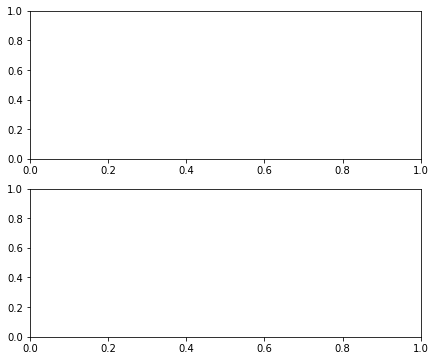

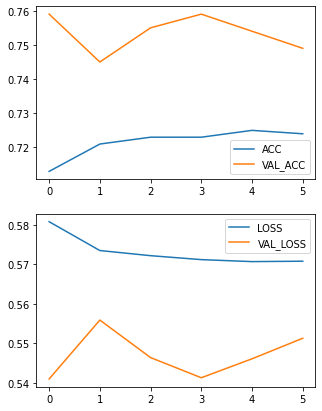

In [9]:
for SPLIT in range(1):
    NAME = EXP_NAME + f"{SPLIT}"
    print(NAME)
    learning_curve_train(NAME)